In [21]:
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt

In [2]:
today = ql.Date(30, 6, 2022)
ql.Settings.instance().evaluationDate = today

# Deutsche Bank AG CDS spreads as of valuation date
tenors = [ql.Period(6, ql.Months), ql.Period(1, ql.Years), ql.Period(2, ql.Years), ql.Period(3, ql.Years),
          ql.Period(4, ql.Years), ql.Period(5, ql.Years), ql.Period(6, ql.Years), ql.Period(7, ql.Years),
          ql.Period(8, ql.Years), ql.Period(9, ql.Years), ql.Period(10, ql.Years)]

spreads = [68.54, 77.66, 92.15, 102.31, 113.61, 128.17, 133.39, 138.61, 142.41, 146.21, 150.01]

## ISDA Standard Upfront Model - Flat hazard rate

Assumes flat hazard rate. 
Recall the survaval probability
$$ Q(t) = \exp^{-\frac{s}{1-RR}t}$$
where $\frac{s}{1-RR}$ is the hazard rate

In [20]:
# EUR 10M Deutsche Bank CDS 100bps 20 Dec 2023 upfront -> -25,266 for protection buyer
s = 84.9067 # interpolated spread in bps
RR = 0.4 # recovery rate - isda standard RR
cpn = 100 # coupon in bps

side = ql.Protection.Buyer
nominal = 10e6
cdsSchedule = ql.MakeSchedule(ql.Date(20, 6, 2022), ql.Date(20, 12, 2023), ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

cds = ql.CreditDefaultSwap(side, nominal, cpn / 10000, cdsSchedule, ql.Following, ql.Actual360())

defaultProbability = ql.DefaultProbabilityTermStructureHandle(
    ql.FlatHazardRate(today, ql.QuoteHandle(ql.SimpleQuote(s / 10000 / (1 - RR))), ql.Actual365Fixed())
)

yieldTermStructure = ql.YieldTermStructureHandle(ql.FlatForward(today, cpn / 10000, ql.Actual365Fixed()))

engine = ql.IsdaCdsEngine(defaultProbability, RR, yieldTermStructure)
cds.setPricingEngine(engine)
cds.NPV()

-26466.66361058659

Text(0.5, 1.0, 'Probability of Default')

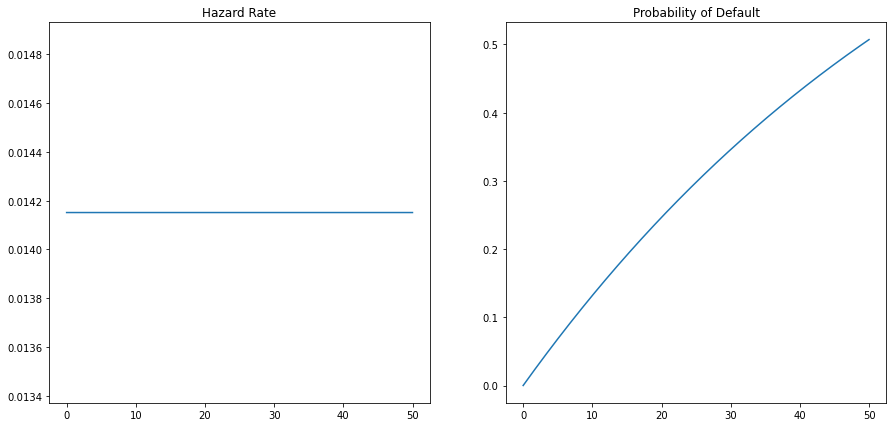

In [37]:
# Plot hazard rate and PD
spread = 150 
t = np.arange(0, 50, 0.01)
hazardRate = np.ones(t.size) * (s / 10000 / (1 - RR))
PD = np.array([defaultProbability.defaultProbability(i) for i in t])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.plot(t, hazardRate)
ax1.set_title("Hazard Rate")
ax2.plot(t, PD)
ax2.set_title("Probability of Default")

## ISDA Fair Value Model - Piecewise constant hazard rate

In [ ]:
CDSHelpers_ctpy = [ql.SpreadCdsHelper((spread / 10000.0), tenor, 0, ql.TARGET(), ql.Quarterly, ql.Following, \
    ql.DateGeneration.TwentiethIMM, ql.Actual360(), RR, ql.YieldTermStructureHandle(yts))
for spread, tenor in zip(spreads, tenors)]

pd_curve = ql.PiecewiseFlatHazardRate(settlementDate, CDSHelpers_ctpy, ql.Thirty360())

engine = ql.IsdaCdsEngine(defaultProbability, RR, yieldTermStructure)
cds.setPricingEngine(engine)
cds.NPV()

In [38]:
ql.DefaultProbabilityTermStructureHandle()

<QuantLib.QuantLib.DefaultProbabilityTermStructureHandle; proxy of <Swig Object of type 'Handle< DefaultProbabilityTermStructure > *' at 0x000001CD21387CF0> >